In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('FrozenLake-v0')

In [3]:
tf.reset_default_graph()

In [4]:
# These lines establish the feed-forward part of the network used to choose actions
inputs = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16, 4], 0, 0.01))
Q_out = tf.matmul(inputs, W)
predict_op = tf.argmax(Q_out, 1)

# Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values
next_Q = tf.placeholder(shape=[1, 4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(next_Q - Q_out))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
update_op = optimizer.minimize(loss)

In [7]:
gamma = 0.99
epsilon = 0.1
n_episodes = 2000

In [9]:
js = []
rewards = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_episodes):
        s = env.reset()  # reset environment and get first new observation
        total_reward = 0
        d = False
        j = 0
        while j < 99:
            j += 1
            # Choose an action by greedily (with noise) picking from Q table
            a, all_Q = sess.run([predict_op, Q_out], feed_dict={inputs: np.identity(16)[s: s+1]})
            
            # exploit or explore
            if np.random.rand(1) < epsilon:
                a[0] = env.action_space.sample()
            
            # Get new state and reward from environment
            s1, r, d, _ = env.step(a[0])
            
            # Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Q_out, feed_dict={inputs: np.identity(16)[s1: s1+1]})
            
            # Obtain max_Q' and set out target value for chosen action
            max_Q1 = np.max(Q1)
            target_Q = all_Q
            target_Q[0, a[0]] = r + gamma * max_Q1
            
            # Train our network using target and predicted Q values
            _, W1 = sess.run([update_op, W], feed_dict={inputs: np.identity(16)[s: s+1], next_Q: target_Q})

            total_reward += r
            s = s1
            if d == True:
                # Reduce exploration as the model trains
                epsilon = 1. / ((i / 50) + 10)
                break

        js.append(j)
        rewards.append(total_reward)

In [12]:
print('% of successful episodes:', str(sum(rewards) / n_episodes))

% of successful episodes: 0.4645


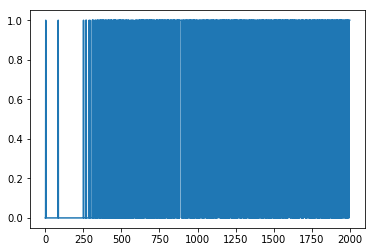

In [11]:
plt.plot(rewards)

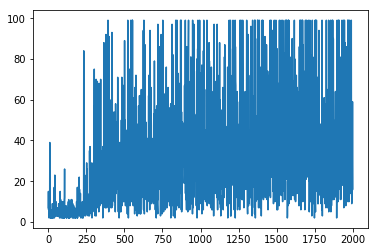

In [13]:
plt.plot(js)